In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

### Utility Function

In [2]:
def print_p_value(unique_cntry, other_count_data):
    
    print('{0:15s} {1:>10s} {2:>25s}'.format('Country', 'P-Value', 'NULL Hypothesis'))
    print('-' * 55)
    
    for cntry in unique_cntry:
        cntry_data = other_count_data[other_count_data['country'] == cntry]
        get_p_value(cntry, cntry_data)
    

In [3]:
def get_p_value(cntry, cntry_data):
    
    p_val_threshold = 0.05
    
    cntry_data_control = cntry_data[cntry_data['test']==0]
    cntry_data_test = cntry_data[cntry_data['test']==1]
    
    control_value = cntry_data_control['conversion']
    test_value = cntry_data_test['conversion']
    
    p_val = ttest_ind(control_value, test_value, equal_var=False).pvalue
    
    null_hypo_res = "REJECT" if p_val < p_val_threshold  else "ACCEPT"
    
    print('{0:15s} {1:15.5e} {2:>15s}'.format(cntry, p_val, null_hypo_res))
    
    
 

### Load Data Set

In [4]:
test_data = pd.read_csv("C:/Users/udit.anand/OneDrive - Synpulse/UserRoaming/Desktop/DataScience/SpanishTranslationABTest/test_table.csv")
user_data = pd.read_csv("C:/Users/udit.anand/OneDrive - Synpulse/UserRoaming/Desktop/DataScience/SpanishTranslationABTest/user_table.csv")

### Data Exploration

In [5]:
# looking the column names
print(test_data.columns)
print(user_data.columns)

Index(['user_id', 'date', 'source', 'device', 'browser_language',
       'ads_channel', 'browser', 'conversion', 'test'],
      dtype='object')
Index(['user_id', 'sex', 'age', 'country'], dtype='object')


#### STEP1: Check the num of unique entries. Since we will be merging the two data sets we want to understand how much of ground work would be involved in merging.

In [6]:
print("Count of user_id in test data: " + str(len(test_data.user_id)))
print("Count of user_id in user data: " + str(len(user_data.user_id)))

Count of user_id in test data: 453321
Count of user_id in user data: 452867


In [7]:
print("Count of unique user_id in test data: " + str(len(test_data.user_id.unique())))
print("Count of unique user_id in user data: " + str(len(user_data.user_id.unique())))

Count of unique user_id in test data: 453321
Count of unique user_id in user data: 452867



#### STEP2: Since all entries are unique we can go ahead and join the data sets on 'user_id'.

There are no duplicate user_id which is good as it reduces the data preprocessing work

In [8]:
data = pd.merge(test_data, user_data, how='inner', on=['user_id'])

In [9]:
data.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0,M,32,Spain
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1,M,21,Mexico
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0,M,34,Spain
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1,F,22,Mexico
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1,M,19,Mexico


### A/B Testing

#### STEP3: Visualizing the current version rate. Based on the information we expect Spain to outperform the other countries

        country  conversion
14        Spain    0.079719
6   El Salvador    0.053554
10    Nicaragua    0.052647
4    Costa Rica    0.052256
3      Colombia    0.052089
8      Honduras    0.050906
7     Guatemala    0.050643
16    Venezuela    0.050344
13         Peru    0.049914
9        Mexico    0.049495
1       Bolivia    0.049369
5       Ecuador    0.049154
12     Paraguay    0.048493
2         Chile    0.048107
11       Panama    0.046796
0     Argentina    0.015071
15      Uruguay    0.012048


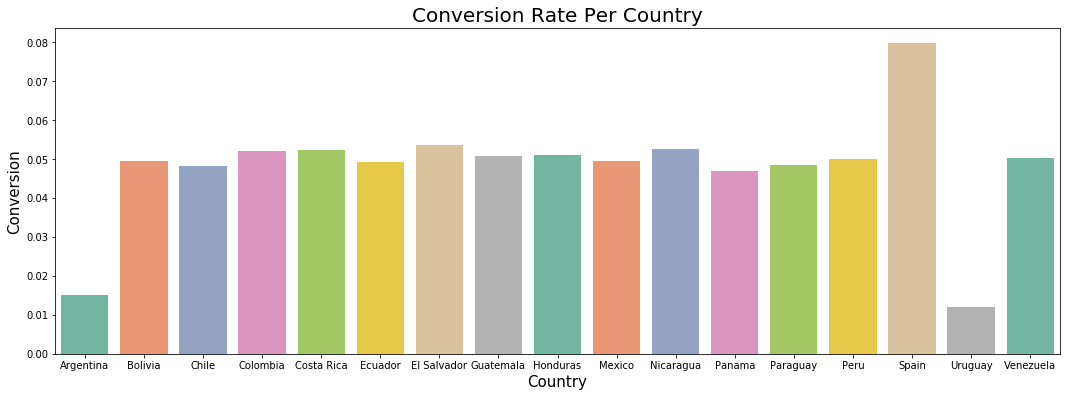

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 6))

data_control_group = data[data['test'] ==0]
group_by_country = data_control_group[['conversion', 'country']].groupby('country').mean().reset_index()
ax= sns.barplot(x='country', y='conversion', data=group_by_country, palette = 'Set2')
ax.set_title('Conversion Rate Per Country', fontsize=20)
ax.set_ylabel('Conversion', fontsize = 15)
ax.set_xlabel('Country', fontsize = 15)
print(group_by_country.sort_values(by=['conversion'], ascending=False)) 

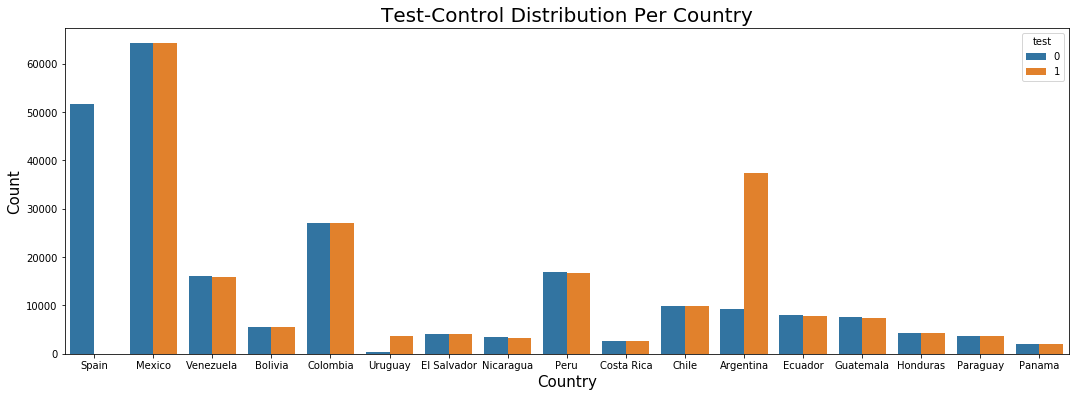

In [11]:
fig, ax = plt.subplots(figsize=(18, 6))
sns.countplot(x='country', hue='test', data=data, ax=ax)
ax.set_title('Test-Control Distribution Per Country', fontsize=20)
ax.set_ylabel('Count', fontsize = 15)
ax.set_xlabel('Country', fontsize = 15)
plt.show()

#### STEP4: Since we do not expect Spain to be affected by the given problem we can remove it from the data set

In [12]:
other_count_data = data[data['country'] != 'Spain']
other_count_data_control = other_count_data[other_count_data['test']==0]
other_count_data_test = other_count_data[other_count_data['test']==1]

control_value = other_count_data_control['conversion']
test_value = other_count_data_test['conversion']

print("Control Group:: Size: " + str(len(control_value)))
print("Control Group:: Mean: " + str(control_value.mean()))
print("Control Group:: SD: " + str(control_value.std()))
print("\n")
print("Test Group:: Size: " + str(len(test_value)))
print("Test Group:: Mean: " + str(test_value.mean()))
print("Test Group:: SD: " + str(test_value.std()))

Control Group:: Size: 185311
Control Group:: Mean: 0.04829179055749524
Control Group:: SD: 0.2143826987826136


Test Group:: Size: 215774
Test Group:: Mean: 0.043411161678422794
Test Group:: SD: 0.20378131704133629


#### STEP5: Before moving ahead, lets define our null and alternate hypothesis. 

Null Hypo: The difference in the mean is random and out of chance i.e. The decline in conversion rate happened by chance. 

Alternate Hypo: The difference in the mean is not random and can be repeated again if the experiment is performed again i.e. 

The decline in conversion rate did not happen by chance but by some other factor. Statistically to conclude that the language change had no effect on the conversion we would like to accept the null hypothesis.
    

#### STEP6: Perform t test

In [13]:
print(ttest_ind(control_value, test_value, equal_var=False)) 

Ttest_indResult(statistic=7.353895203080277, pvalue=1.9289178577799033e-13)


#### STEP7: A lower p-value indicates that the result did not happen by chance. Usually a p-value of greater than 0.05 is required to 
#### reject the null hypothesis. Based on our current result it seems that the we have very strong evidence against rejecting the null 
#### hypothesis.

#### STEP8: Let's looks at how did each country fare as the overall results do not look promising

In [14]:
unique_cntry = other_count_data['country'].unique()

In [15]:
print_p_value(unique_cntry, other_count_data)

    

Country            P-Value           NULL Hypothesis
-------------------------------------------------------
Mexico              1.65544e-01          ACCEPT
Venezuela           5.73702e-01          ACCEPT
Bolivia             7.18885e-01          ACCEPT
Colombia            4.23719e-01          ACCEPT
Uruguay             8.79764e-01          ACCEPT
El Salvador         2.48127e-01          ACCEPT
Nicaragua           7.80400e-01          ACCEPT
Peru                7.71953e-01          ACCEPT
Costa Rica          6.87876e-01          ACCEPT
Chile               3.02848e-01          ACCEPT
Argentina           3.35147e-01          ACCEPT
Ecuador             9.61512e-01          ACCEPT
Guatemala           5.72107e-01          ACCEPT
Honduras            4.71463e-01          ACCEPT
Paraguay            8.83697e-01          ACCEPT
Panama              7.05327e-01          ACCEPT


### Summary
1. Spain as expected has the best conversion rate.
2. For other Latam countries  when observed together it seems that the language change did have a negative impact on conversion
3. However, when analyzed for each country the result was more favorable i.e the impact of language change on conversion was statistically non significant
4. Possible reasons why we see a discrepany between results when countries are dealt with together or when they are dealt individually could be effect of extremely skewed control or test groups. For example, Argentina and Uruguay as shown above have a high number of test samples as compared to control. 
5. In an ideal environment we would expect the count of control and test variables across all countries to be close if not identical.